In [ ]:
2+2

4

In [ ]:
!pip install -U langchain langchain_openai langsmith pandas langchain_experimental matplotlib langgraph langchain_core langchain_community langchain_groq pygithub

In [ ]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("GROQ_API_KEY") # z
_set_if_undefined("TAVILY_API_KEY") # T

In [ ]:
os.environ["Git_api"] = getpass.getpass("Please provide your GROQ_API_KEY") # 

Please provide your GROQ_API_KEY··········


In [ ]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.file_management import WriteFileTool
# from langchain_community.agent_toolkits.github.toolkit import GitHubToolkit
# from langchain_community.utilities.github import GitHubAPIWrapper

tavily_tool = TavilySearchResults(max_results=5)
repl = PythonREPL()

# github = GitHubAPIWrapper()
# toolkit = GitHubToolkit.from_github_api_wrapper(github)
# git_tools = [tool for tool in toolkit.get_tools() if tool.name == "Read File"]


@tool
def python_repl( code: Annotated[str, "The python code to execute to generate your chart."], ):
    """Use this to execute python code. If you want to see the output of a value, you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

@tool
def markdown_saver( code: Annotated[str, "The markdown code to generate your chart."], MD_file = "report.md" ):
    """ave provided content to a .md file in Markdown format."""
    try:
        with open(MD_file, "w") as file:
            file.write(code)
        print(f"Content successfully saved to {MD_file}")
    except Exception as e:
        print(f"An error occurred: {e}")


@tool
def dataset_links(code: Annotated[str, "The python code to execute to generate your chart."], link_file = "note.txt"):
    """Use this to execute python code. If you want to see the output of a value, you should print it out with `print(...)`. This is visible to the user."""
    try:
        with open(link_file, "w") as file:
            file.write(code)
        print(f"Content successfully saved to {link_file}")
    except Exception as e:
        print(f"An error occurred: {e}")

In [ ]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph, START

def research_agent(llm, tools, system_message: str):
    """Create an agent.1"""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                " Role : Combined Agent for Company Analysis & Use Case Generation"
                " Gole : Conduct a comprehensive analysis of the given company and its industry. Identify key offerings, strategic goals, and industry trends, then propose actionable GenAI and ML use cases that align with the company’s operational and customer experience objectives."
                " Backstory : A hybrid agent blending strategic analysis with visionary AI expertise, InsightForge specializes in understanding a company’s industry landscape while uncovering innovative AI/ML applications to enhance business processes and customer experiences. With its foundations in competitive intelligence and AI trend analysis, InsightForge provides insights and use cases that serve as a roadmap for impactful digital transformation."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)


def dataset_agent(llm, tools, system_message: str):
    """Create an agent.2"""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                " Role : Resource Asset Collection Agent"
                " Gole :Gather relevant datasets for the proposed use cases from platforms like Kaggle, HuggingFace, and GitHub, organizing clickable resource links in a markdown file. Optionally, recommend GenAI solutions, such as document search, automated reporting, or AI-powered chat systems."
                " Backstory : A resourceful data specialist, DataScout excels at finding and organizing datasets that power AI solutions. With a strong background in data science and an eye for practical applications, DataScout not only curates essential resources but also suggests GenAI tools to enhance both internal efficiency and customer engagement."
                " prefix your response with FINISH so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

In [ ]:
import operator
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI


# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

In [ ]:
import functools
from langchain_core.messages import AIMessage
from langchain_groq import ChatGroq

# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return { "messages": [result], "sender": name}


llm = ChatGroq(model="llama-3.1-8b-instant")

# Research agent and node
research_task = research_agent(
    llm,
    [tavily_tool],
    system_message = """Research the given company and its industry segment. Identify its key offerings, focus areas
        (e.g., operations, customer experience), and strategic goals. Note the company’s position within the
        industry and any relevant vision or mission statements. And You should provide accurate data for the trend_generator to use.""",
)

# Market Standards & Use Case Generation Agent
generation_task = research_agent(
    llm,
    [tavily_tool, markdown_saver],
    system_message = """Based on the industry conducted given by Researcher, analyze industry trends and standards within the company’s sector related to
        AI, ML, and automation. Propose relevant use cases where the company can leverage GenAI, LLMs, and ML technologies to improve their processes,
        enhance customer satisfaction, and boost operational efficiency. At last finish the answer by generate this response in mardown format and save that.""",
)

# Agent: DataScout
data_task = dataset_agent(
    llm,
    [tavily_tool, dataset_links],
    system_message = """Collect the above use cases generated and search for relevant datasets on platforms like Kaggle, HuggingFace, and GitHub.
        Save the resource links fetched in a text file. propose GenAI solutions like document search, automated report generation, and AI-powered chat
        systems for internal or customer-facing purposes.""",
)



research_node = functools.partial(agent_node, agent=research_task, name="Researcher")
generate_node = functools.partial(agent_node, agent=generation_task, name="trend_generator")
data_node = functools.partial(agent_node, agent=data_task, name="datascout")

In [ ]:
from langgraph.prebuilt import ToolNode

tools = [tavily_tool, markdown_saver, python_repl, dataset_links]
tool_node = ToolNode(tools)

In [ ]:
# Either agent can decide to end
from typing import Literal


def router(state):
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]

    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"

    if "FINISH" in last_message.content or "FINAL ANSWER" in last_message.content:
        return END

    return "continue"

In [ ]:
workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("trend_generator", generate_node)
workflow.add_node("datascout", data_task)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "trend_generator", "call_tool": "call_tool"},
)
workflow.add_conditional_edges(
    "trend_generator",
    router,
    {"continue": "datascout", "call_tool": "call_tool"},
)
workflow.add_conditional_edges(
    "datascout",
    router,
    {"call_tool": "call_tool", END: END},
)

workflow.add_conditional_edges(
    "call_tool",
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "trend_generator": "trend_generator",
        "datascout": "datascout"
    },
)
workflow.add_edge(START, "Researcher")
graph = workflow.compile()

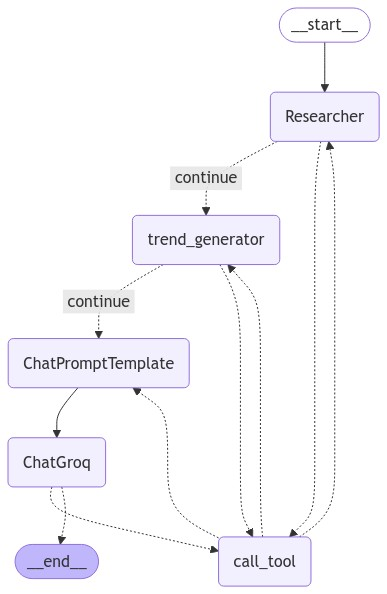

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Company name Wipro"
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("---------------------")

BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '<function=tavily_search_results_json>{"query": "Wipro company overview"}"</function>\n<function=tavily_search_results_json>{"query": "Wipro industry trends"}"</function>\n<function=tavily_search_results_json>{"query": "Wipro key offerings"}"</function>\n<function=tavily_search_results_json>{"query": "Wipro strategic goals"}"</function>\n<function=tavily_search_results_json>{"query": "Wipro company mission statement"}"</function>\n<function=tavily_search_results_json>{"query": "Wipro company vision statement"}"</function>'}}

In [ ]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Company name Banao Technology"
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print("->", s)
    print("---------------------")

-> {'Researcher': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_13s9', 'function': {'arguments': '{"query": "Banao Technology company overview"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_xkew', 'function': {'arguments': '{"query": "Banao Technology industry segment"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_v2ar', 'function': {'arguments': '{"query": "Banao Technology key offerings"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_b7th', 'function': {'arguments': '{"query": "Banao Technology focus areas"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_k8nq', 'function': {'arguments': '{"query": "Banao Technology strategic goals"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_t0mp', 'function': {'arguments': '{"query": "Banao Technology industry trends"}', 'name': 'tavily_search_results_json'}, 'type':

InvalidUpdateError: Must write to at least one of ['messages', 'sender']

In [ ]:
for s in events:
    print("->", s)
    print("---------------------")

In [ ]:
print(s[list(s.keys())[0]]['messages'][0].content)

This markdown file summarizes the analysis of Banao Technology, including their key offerings, focus areas, strategic goals, position in the industry, vision or mission statement, current trends, and actionable GenAI and ML use cases.


In [ ]:
print(list(s.keys())[0])

Researcher
